## Методические указания по выполнению лабораторной работы №3

**Тема: Обнаружение объектов с использованием Faster R-CNN**

**Цель работы:** Ознакомиться с архитектурой Faster R-CNN и принципами двухэтапного обнаружения объектов.

**Задачи:**
- Изучить теоретические основы двухэтапного обнаружения объектов: роль RPN и классификационного этапа в Faster R-CNN.
- Загрузить предобученную модель Faster R-CNN.
- Ознакомиться с форматом аннотаций для обучения в задаче детекции.
- Визуализировать предсказания, проанализировать ошибки модели и провести исследование по поиску баланса FN/FP.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Faster R-CNN](https://arxiv.org/pdf/1506.01497), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новым форматом данных для обучения нейро-сетевых моделей детекции. Для оценки модели воспользуемся набором данных [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/).

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/master/models/faster_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Архитектура Faster R-CNN

Существует два основных подхода к обнаружению объектов:
Двухстадийные модели – более точные, но медленные.
Одностадийные модели – быстрые, но менее точные.

Faster R-CNN — это двухэтапная модель детекции объектов. В отличие от ResNeXt, Faster R-CNN не просто классифицирует изображение, а находит на нём несколько объектов, предсказывает bounding boxes и присваивает метки классам. Она состоит из следующих компонентов:

1. Backbone (ResNet/VGG/MobileNet) – извлекает признаки из изображения.
2. Region Proposal Network (RPN) – предлагает области, где могут находиться объекты.
3. ROI Pooling + Fully Connected Layers – классифицирует объекты и уточняет bounding boxes.
4. Non-Maximum Suppression (NMS) – убирает дублирующиеся предсказания.


В предыдущих лабораторных работах мы познакомились с классификацией изображений, где модель предсказывает единственный класс для всего изображения. Однако во многих задачах компьютерного зрения классификация недостаточна. Например, когда на одном изображении присутствуют несколько объектов разных классов необходимо не только определить, что изображено, но и где это находится.

Faster R-CNN –  модель, которая также решает задачу обнаружения объектов, добавляя к классификации локализацию.

#### 1.2 Формат данных для задачи детекции

Faster R-CNN требует разметки изображений, помимо классов включающей в себя и координаты bounding box по оси x, y.
Ознакомьтесь с форматом набора данных Pascal VOC, скачайте аннотации набора данных и изучите структуру **.xml** файлов в папке Annotations по [ссылке](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtestnoimgs_06-Nov-2007.tar).

#### 1.3 Оценка качества

Помимо известных вам инструментов оценить качество работы детектора могут помочь:

Confidence Score - значение, указывающее на уверенность модели в том, что на данном месте изображения находится объект. Модель предсказывает этот параметр для каждого предсказанного bounding box. Чем выше confidence score, тем более уверена модель в своём предсказании.

Фильтрация предсказаний - модель может предсказать много объектов, но не все из них будут точными. Чтобы уменьшить количество ложных срабатываний (False Positives), применяется фильтр предсказаний, используя confidence threshold. Если confidence score меньше заданного порога - предсказание отбрасывается.


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки импортированы")

Библиотеки успешно импортированы


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Определение устройства
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Используется устройство: {device}")

# Перевод модели в режим инференса
model.to(device)
model.eval()

Используется устройство: cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель. Он понадобится позже для преобразования изображений при прямом проходе через модель чтобы получить предсказания:

In [21]:
test_dataset = tfds.load(
    "voc/2007",
    split="test",
    shuffle_files=False,
)

voc_dataset = list(tfds.as_numpy(test_dataset))

print(f"Датасет загружен. Количество изображений: {len(voc_dataset)}")

def transform_image(image):
    pil_image = Image.fromarray(image.astype(np.uint8))
    image_tensor = F.to_tensor(pil_image)
    return image_tensor

print("Метод трансформации определен")

Датасет загружен. Количество изображений: 4952
Метод трансформации определен


#### 2.4 Объявление методов для работы с данными

Далее необходимо создать методы препроцессинга: метод чтения файла аннотации для возврата numpy-объекта содержащего bounding boxes, и метод отрисовки истиных и прогнозных bounding boxes на изображении для визуализации полученных результатов.

In [7]:

from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = (int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                                  int(bbox.find("xmax").text), int(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
    return np.array(boxes)

def draw_predictions(image, boxes, labels, scores, color="blue"):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        draw.text((xmin, ymin), f"{label} ({score:.2f})", fill=color)
    return image

#### 2.5 Анализ False Positives / False Negatives

Для измерения того, насколько хорошо bounding box предсказан, применяется параметр IoU (Intersection over Union) между двумя bounding boxes. Чем он выше, тем точнее предсказание. Для его оценки опишем следующий метод, принимающий два np.array-объекта (прогнозные и истинные координаты):

In [9]:
def calculate_iou(pred_box, gt_box):
    x1, y1, x2, y2 = pred_box
    x1g, y1g, x2g, y2g = gt_box

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

#### 2.6 Оценка модели и визуализация результатов

Выполните прямой проход нескольких изображений через модель. Для этого необходимо загрузить изображения и аннотации, применить преобразование изображений в тензор. Затем получите выходы модели:

Анализ 5 изображений.


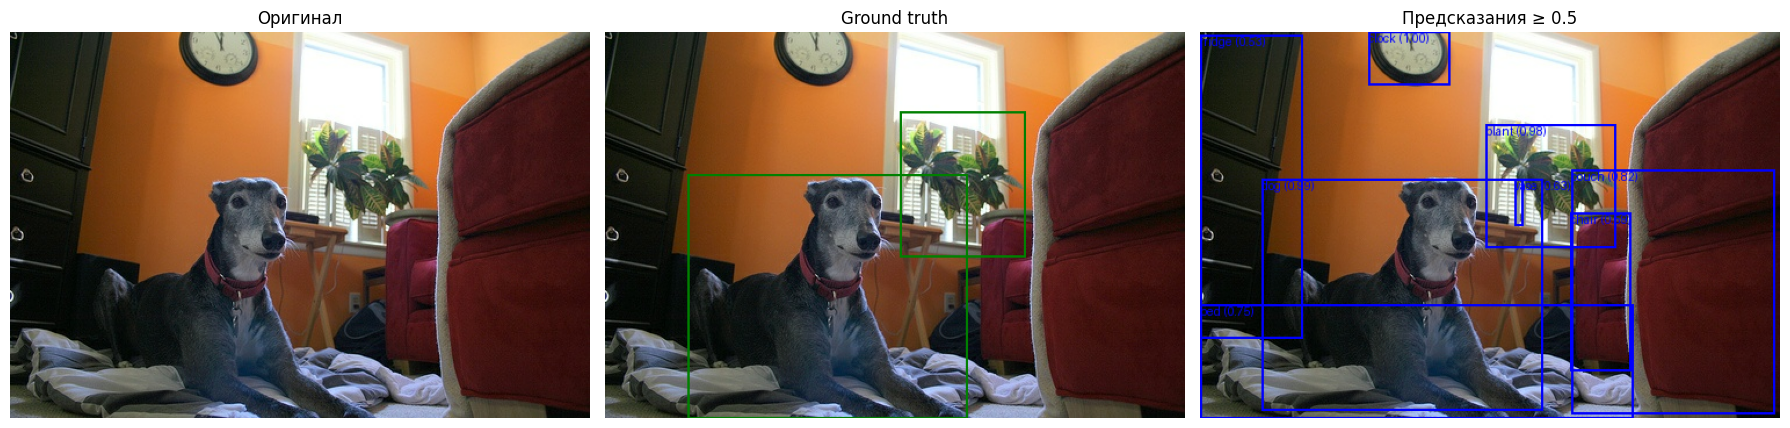

Изображение 1:
  Ground truth: 2
  Предсказания: 8
  FP: 6
  FN: 0
  TP: 2
--------------------------------------------------


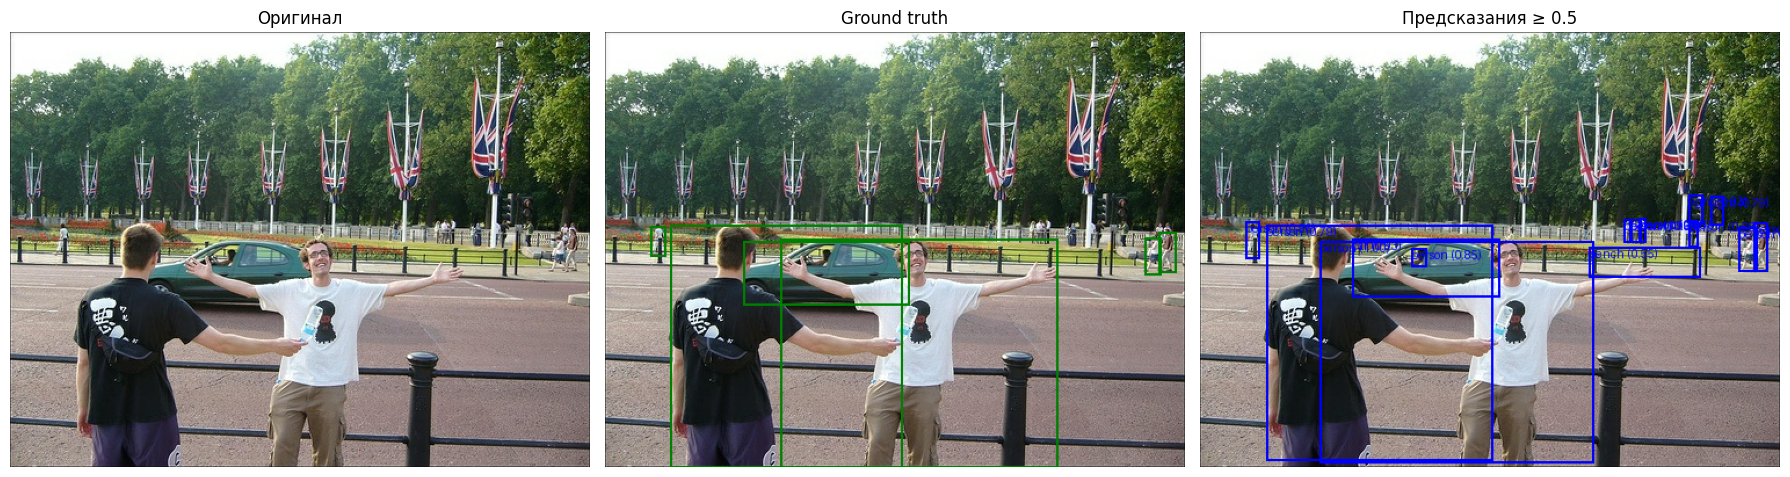

Изображение 2:
  Ground truth: 6
  Предсказания: 14
  FP: 8
  FN: 0
  TP: 6
--------------------------------------------------


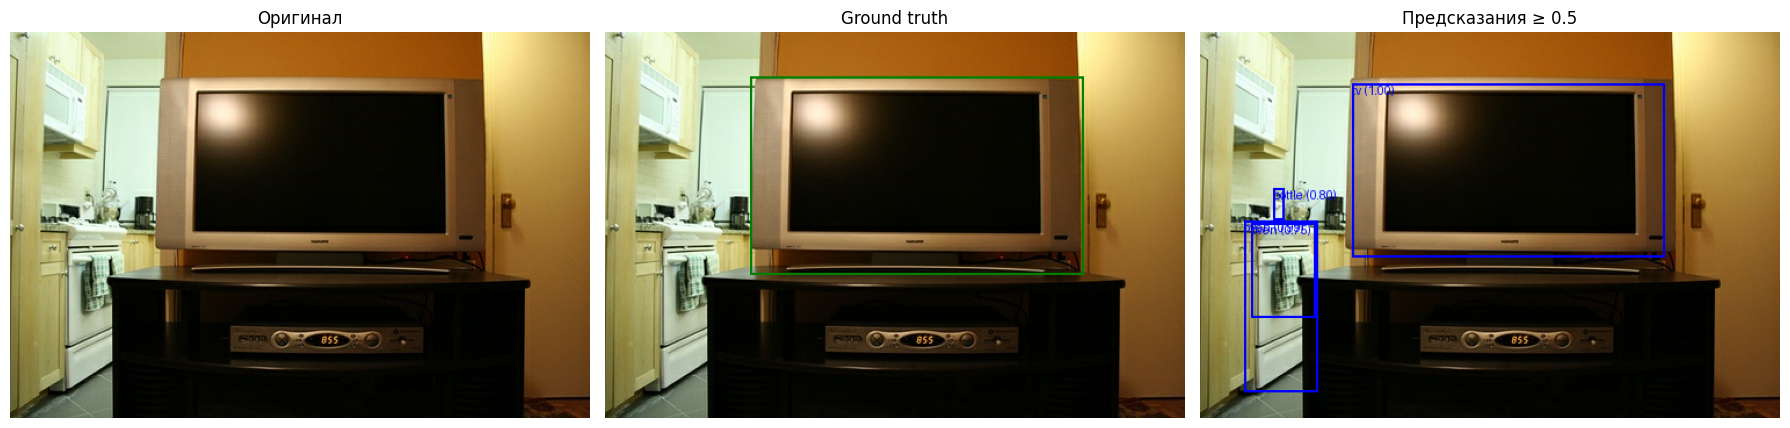

Изображение 3:
  Ground truth: 1
  Предсказания: 4
  FP: 3
  FN: 0
  TP: 1
--------------------------------------------------


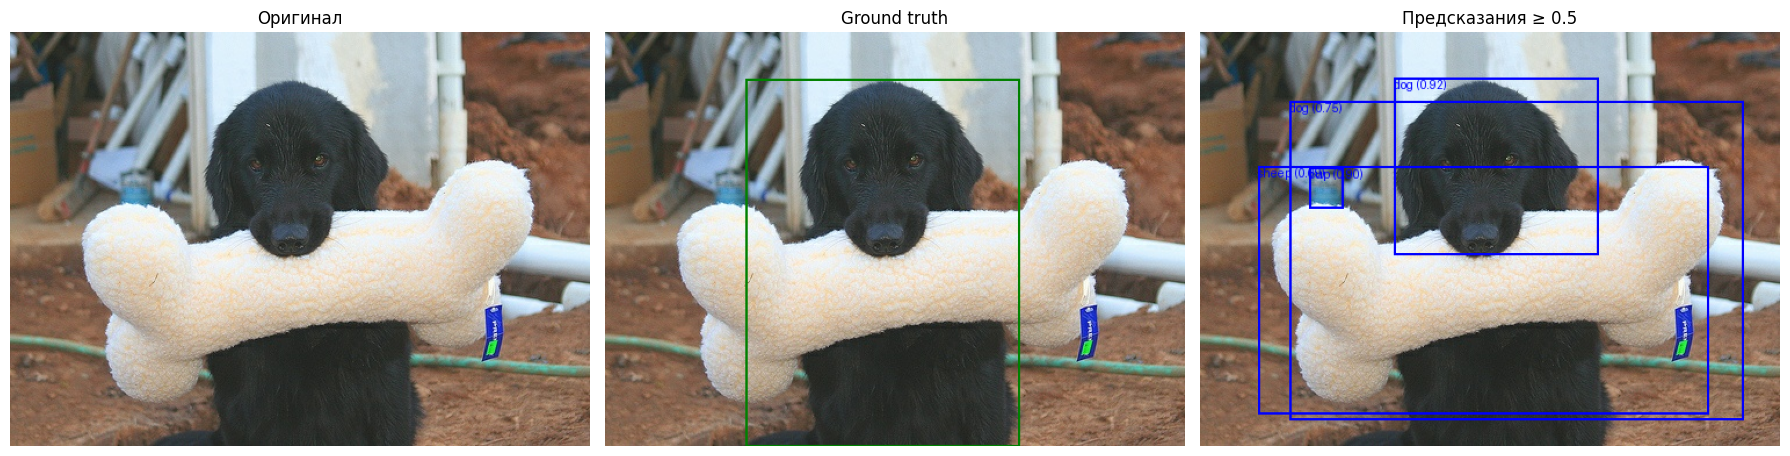

Изображение 4:
  Ground truth: 1
  Предсказания: 4
  FP: 3
  FN: 0
  TP: 1
--------------------------------------------------


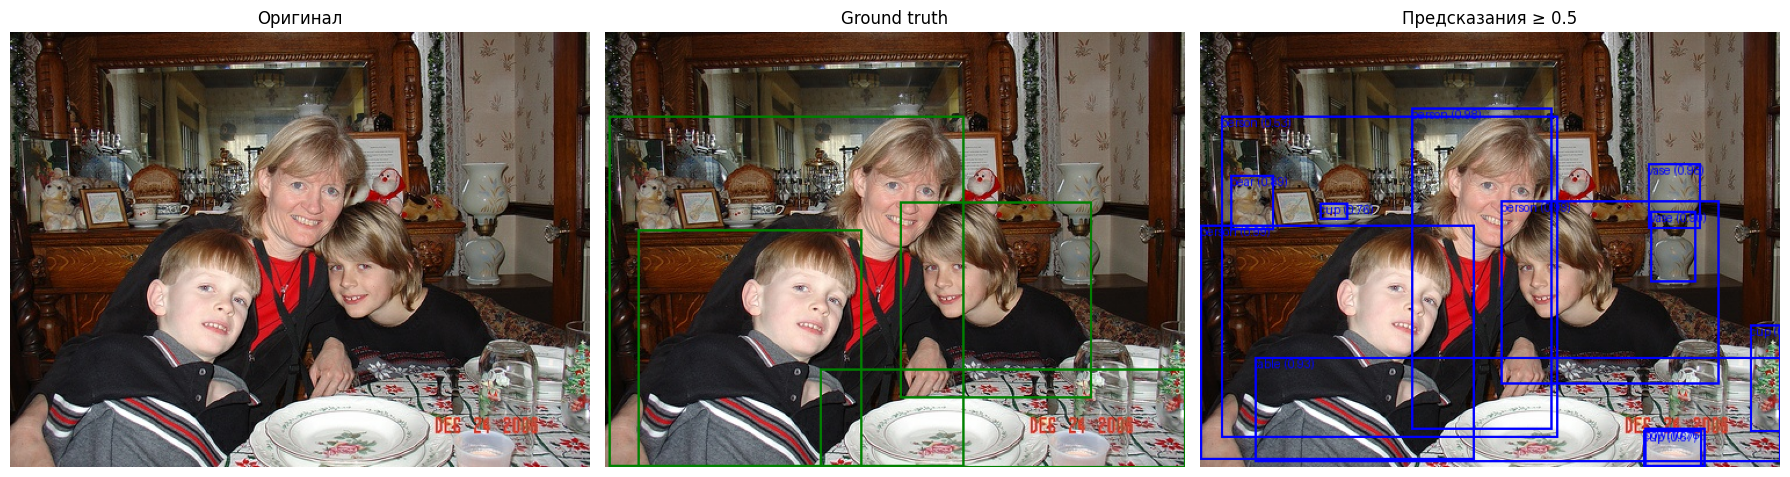

Изображение 5:
  Ground truth: 4
  Предсказания: 12
  FP: 9
  FN: 1
  TP: 3
--------------------------------------------------
Итог 5 изображений:
FP: 29
FN: 1


In [19]:
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = (int(bbox.find("xmin").text), int(bbox.find("ymin").text),
                                  int(bbox.find("xmax").text), int(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
    return np.array(boxes)

def draw_predictions(image, boxes, labels, scores, color="blue"):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        draw.text((xmin, ymin), f"{label} ({score:.2f})", fill=color)
    return image

2.5	Анализ False Positives / False Negatives
Для измерения того, насколько хорошо bounding box предсказан, применяется параметр IoU (Intersection over Union) между двумя bounding boxes. Чем он выше, тем точнее предсказание. Для его оценки опишем следующий метод, принимающий два np.array-объекта (прогнозные и истинные координаты):

2.6	Оценка модели и визуализация результатов
Выполните прямой проход нескольких изображений через модель. Для этого необходимо загрузить изображения и аннотации, применить преобразование изображений в тензор. Затем получите выходы модели:
Category = [
    '__bg__', 'person', 'bike', 'car', 'moto', 'plane', 'bus',
    'train', 'truck', 'boat', 'light', 'hydrant', 'N/A', 'sign',
    'meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'pack', 'umbrella', 'N/A', 'N/A',
    'bag', 'tie', 'case', 'disc', 'skis', 'board', 'ball',
    'kite', 'bat', 'glove', 'skate', 'surf', 'racket',
    'bottle', 'N/A', 'glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'plant', 'bed', 'N/A', 'table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'phone',
    'microwave', 'oven', 'toaster', 'sink', 'fridge', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'bear', 'drier', 'brush'
]
N = 5
fp_tot = 0
fn_tot = 0

print(f"Анализ {N} изображений.")

for i in range(N):
    # Загрузка изображения и аннотаций
    d = voc_dataset[i]
    img = d['image']
    objs = d['objects']

    # Получение ground truth bounding boxes
    gt = []
    for j in range(len(objs['bbox'])):
        b = objs['bbox'][j]
        # Конвертация формата [y_min, x_min, y_max, x_max] в [x_min, y_min, x_max, y_max]
        h, w = img.shape[0], img.shape[1]
        x1 = int(b[1] * w)
        y1 = int(b[0] * h)
        x2 = int(b[3] * w)
        y2 = int(b[2] * h)
        gt.append([x1, y1, x2, y2])

    gt = np.array(gt)

    # Применение трансформаций
    x = transform_image(img).unsqueeze(0).to(device)

    # Выполнение прямого прохода
    with torch.no_grad():
        out = model(x)

    # Извлекаем bounding boxes, метки и confidence scores из полученных выходов модели
    pred_boxes = out[0]['boxes'].cpu().numpy()
    pred_labels = out[0]['labels'].cpu().numpy()
    pred_scores = out[0]['scores'].cpu().numpy()
    confidence_threshold = 0.5

    # Фильтрация по порогу уверенности
    m = pred_scores >= confidence_threshold
    boxes_f = pred_boxes[m]
    labels_f = pred_labels[m]
    scores_f = pred_scores[m]

    # Конвертация для визуализации
    pil = Image.fromarray(img.astype(np.uint8))

    # Отрисовка ground truth (зеленый)
    img_gt = pil.copy()
    for b in gt:
        dr = ImageDraw.Draw(img_gt)
        x1, y1, x2, y2 = map(int, b)
        dr.rectangle([x1, y1, x2, y2], outline="green", width=2)

    # Отрисовка предсказаний (синий)
    img_pred = pil.copy()
    for b, l, s in zip(boxes_f, labels_f, scores_f):
        dr = ImageDraw.Draw(img_pred)
        x1, y1, x2, y2 = map(int, b)
        dr.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        cls = Category[l] if l < len(Category) else f"Cls_{l}"
        dr.text((x1, y1), f"{cls} ({s:.2f})", fill="blue")

    # Создание комбинированного изображения
    fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(18, 6))

    # Оригинальное изображение
    a1.imshow(pil)
    a1.set_title('Оригинал')
    a1.axis('off')

    # Ground truth
    a2.imshow(img_gt)
    a2.set_title('Ground truth')
    a2.axis('off')

    # Предсказания
    a3.imshow(img_pred)
    a3.set_title(f'Предсказания ≥ {confidence_threshold}')
    a3.axis('off')

    plt.tight_layout()
    plt.show()

    # Вычисление IoU и подсчет FP/FN
    print(f"Изображение {i+1}:")
    print(f"  Ground truth: {len(gt)}")
    print(f"  Предсказания: {len(boxes_f)}")

    # Подсчет FP и FN
    iou_t = 0.5
    m_gt = set()
    m_pred = set()

    # Сопоставление предсказаний с ground truth
    for p_idx, p_b in enumerate(boxes_f):
        for g_idx, g_b in enumerate(gt):
            iou = calculate_iou(p_b, g_b)
            if iou >= iou_t and g_idx not in m_gt:
                m_gt.add(g_idx)
                m_pred.add(p_idx)
                break

    fp = len(boxes_f) - len(m_pred)  # False Positives
    fn = len(gt) - len(m_gt)         # False Negatives

    print(f"  FP: {fp}")
    print(f"  FN: {fn}")
    print(f"  TP: {len(m_pred)}")

    fp_tot += fp
    fn_tot += fn

    print("-" * 50)

print(f"Итог {N} изображений:")
print(f"FP: {fp_tot}")
print(f"FN: {fn_tot}")


#### 2.7 Поиск оптимальной конфигурации

Проанализируйте полученные результаты с выбранным значением фильтрации предсказаний. Проведите исследование с целью поиска оптимального порога и баланса FN/FP. Обоснуйте полученные результаты:


СРАВНЕНИЕ РАЗНЫХ ПОРОГОВ


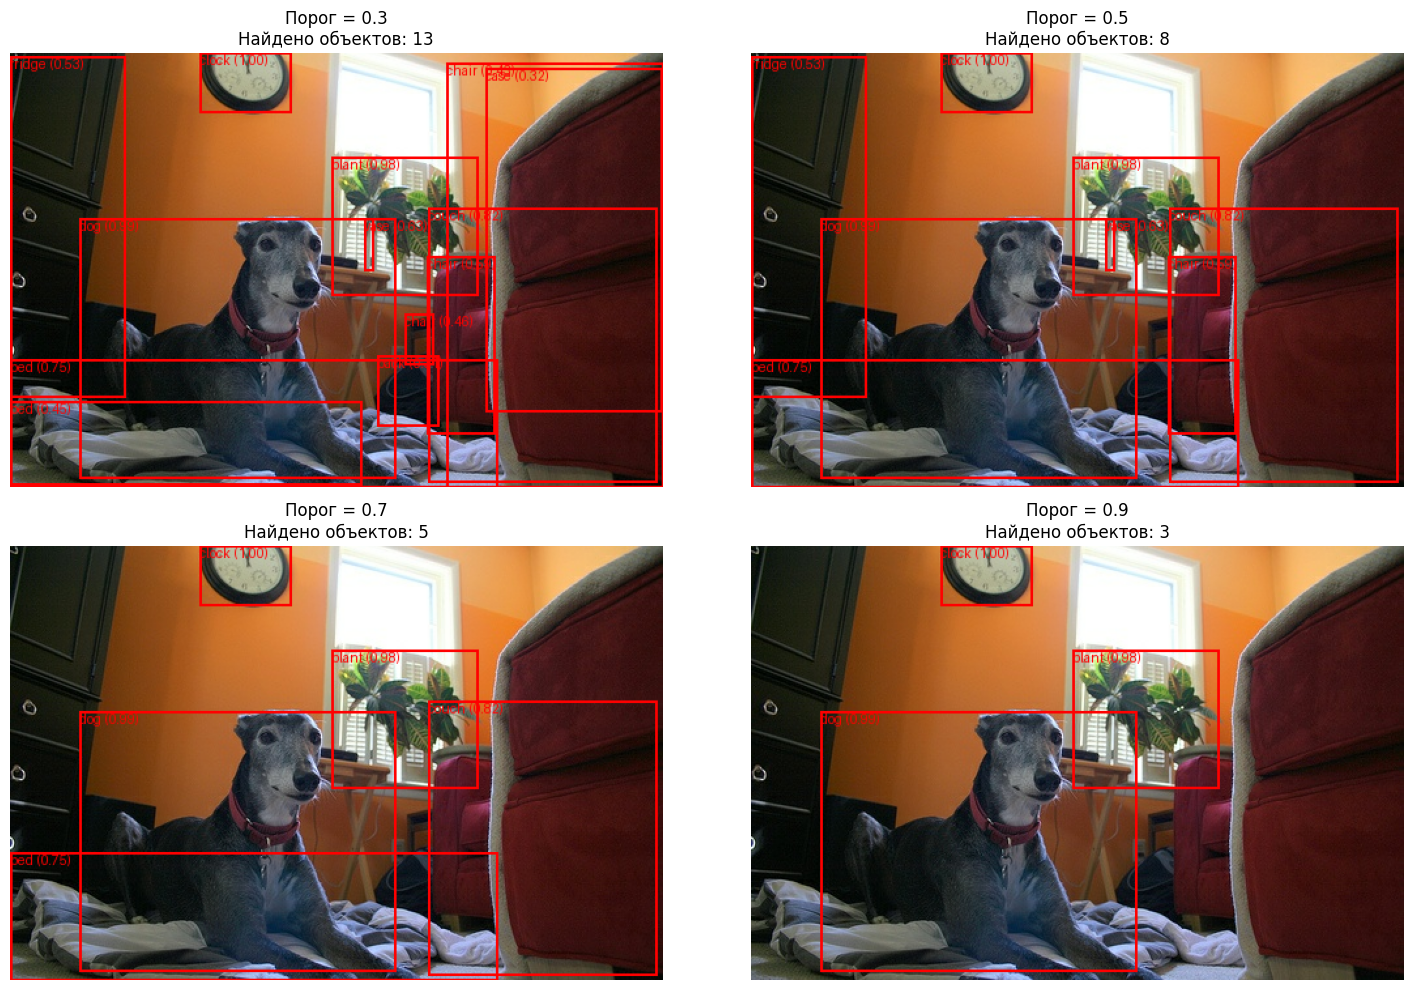


БАЛАНС МЕЖДУ ЛОЖНЫМИ СРАБАТЫВАНИЯМИ И ПРОПУСКАМИ:
Низкий порог → больше ложных обнаружений (FP)
Высокий порог → больше пропущенных объектов (FN)

ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
• 0.3-0.5: Используйте когда критичны пропуски объектов
• 0.5-0.7: Оптимальный баланс для большинства задач
• 0.7-0.9: Выбирайте когда важна точность обнаружений


In [20]:
print("\n" + "="*50)
print("СРАВНЕНИЕ РАЗНЫХ ПОРОГОВ")
print("="*50)

# Проверка разных уровней уверенности
conf_levels = [0.3, 0.5, 0.7, 0.9]
img_index = 0  # Берем первый снимок для анализа

img_data = voc_dataset[img_index]
image = img_data['image']
img_tensor = transform_image(image).unsqueeze(0).to(device)

with torch.no_grad():
    model_output = model(img_tensor)

detection_boxes = model_output[0]['boxes'].cpu().numpy()
detection_labels = model_output[0]['labels'].cpu().numpy()
detection_scores = model_output[0]['scores'].cpu().numpy()

plt.figure(figsize=(15, 10))

for idx, conf_threshold in enumerate(conf_levels):
    # Отбор предсказаний по уверенности
    selection_mask = detection_scores >= conf_threshold
    selected_boxes = detection_boxes[selection_mask]
    selected_labels = detection_labels[selection_mask]
    selected_scores = detection_scores[selection_mask]

    # Отображение результатов
    plt.subplot(2, 2, idx+1)
    output_image = Image.fromarray(image.astype(np.uint8))
    output_image = draw_predictions(output_image, selected_boxes,
                                  [CATS[class_id] for class_id in selected_labels],
                                  selected_scores, color="red")

    plt.imshow(output_image)
    plt.title(f"Порог = {conf_threshold}\nНайдено объектов: {len(selected_boxes)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Оценка компромисса между FP и FN
print("\nБАЛАНС МЕЖДУ ЛОЖНЫМИ СРАБАТЫВАНИЯМИ И ПРОПУСКАМИ:")
print("Низкий порог → больше ложных обнаружений (FP)")
print("Высокий порог → больше пропущенных объектов (FN)")

# Советы по настройке порога
print("\nПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
print("• 0.3-0.5: Используйте когда критичны пропуски объектов")
print("• 0.5-0.7: Оптимальный баланс для большинства задач")
print("• 0.7-0.9: Выбирайте когда важна точность обнаружений")